In [1]:
import os
os.chdir('..')

In [2]:
import pandas as pd

In [3]:
from sklearn.ensemble import RandomForestClassifier

In [4]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

In [5]:
lab_clean = pd.read_csv('data/lab_clean.csv').rename({'SUBJECT_ID': 'subject_id'}, axis=1)

In [6]:
lab_clean.head()

,Unnamed: 0,subject_id,50803,50809,50813,50824,50831,50855,50882,50885,50912,50931,50983,51265,51300,ADMISSION_TYPE_ELECTIVE,ADMISSION_TYPE_EMERGENCY,ADMISSION_TYPE_URGENT,Death
0,0,17,25.0,134.333333,0.900000,137.666667,7.45,13.05,24.352941,0.4,0.752941,114.500000,138.733333,281.750000,7.003922,0.0,1.0,0.0,0.0
1,1,18,25.0,333.000000,3.600000,137.500000,7.45,13.05,25.857143,1.1,0.957143,221.000000,138.571429,224.166667,7.003922,0.0,1.0,0.0,0.0
2,2,24,25.0,132.953157,1.843333,137.500000,7.45,13.05,24.000000,0.5,0.925000,117.000000,140.000000,207.000000,7.003922,0.0,1.0,0.0,0.0
3,3,35,25.0,119.172414,1.843333,139.750000,7.45,13.05,28.100000,0.4,0.700000,133.222222,139.000000,107.500000,7.003922,1.0,0.0,0.0,0.0
4,4,85,24.0,117.150000,1.250000,135.714286,7.45,13.05,24.187500,0.4,1.127778,102.466667,136.600000,96.695652,7.003922,0.0,1.0,0.0,0.0


In [7]:
nlp = pd.read_csv('data/results_nlp.csv')

In [33]:
lv_move = pd.read_csv('data/lv_move.csv')

In [42]:
lv_move = lv_move[lv_move.subject_id.isin(nlp.subject_id)].groupby('subject_id').agg({'lv_move': 'max'}).fillna(1)

In [45]:
for i in [2, 3, 4]:
    lv_move[f'lv_move_{i}'] = lv_move.lv_move == i

In [48]:
lv_move.drop('lv_move', axis=1, inplace=True)

In [49]:
nlp = nlp.join(lv_move, on='subject_id', how='left')

In [50]:
nlp

,subject_id,lvef,tamponade,aorta,lv_move_2,lv_move_3,lv_move_4
0,17,1.0,0.0,0.0,False,False,False
1,18,1.0,0.0,0.0,False,False,False
2,24,1.0,0.0,0.0,True,False,False
3,35,1.0,0.0,0.0,False,False,True
4,85,1.0,0.0,0.0,False,False,False
...,...,...,...,...,...,...,...
1666,26638,4.0,0.0,0.0,False,False,True
1667,26644,1.0,0.0,0.0,False,False,False
1668,26664,1.0,0.0,0.0,False,False,False
1669,26701,2.0,0.0,0.0,False,False,True


In [51]:
data = lab_clean.join(nlp.set_index('subject_id'), on='subject_id', how='left')

In [66]:
for i in [2, 3, 4]:
    data[f'lv_move_{i}'] = data[f'lv_move_{i}'].fillna(data[f'lv_move_{i}'].median())

In [67]:
for c in ['lvef', 'tamponade', 'aorta']:
    data[c] = data[c].fillna(data[c].median())

In [68]:
for i in [1, 2, 3, 4]:
    data[f'lvef_{i}'] = data.lvef == i

In [69]:
data.columns

Index(['Unnamed: 0', 'subject_id', '50803', '50809', '50813', '50824', '50831',
       '50855', '50882', '50885', '50912', '50931', '50983', '51265', '51300',
       'ADMISSION_TYPE_ELECTIVE', 'ADMISSION_TYPE_EMERGENCY',
       'ADMISSION_TYPE_URGENT', 'Death', 'lvef', 'tamponade', 'aorta',
       'lv_move_2', 'lv_move_3', 'lv_move_4', 'lvef_1', 'lvef_2', 'lvef_3',
       'lvef_4'],
      dtype='object')

In [70]:
features_base = [
    '50803',
    '50809',
    '50813',
    '50824',
    '50831',
    '50855',
    '50882',
    '50885',
    '50912',
    '50931', 
    '50983',
    '51265', 
    '51300',
    'ADMISSION_TYPE_ELECTIVE',
    'ADMISSION_TYPE_EMERGENCY',
]

In [71]:
features_nlp = [
    'lvef_1',
    'lvef_2',
    'lvef_3',
    'lvef_4',
    'lv_move_2',
    'lv_move_3', 
    'lv_move_4',
    'tamponade',
    'aorta'
]

In [72]:
outcome = 'Death'

In [73]:
logreg_base = LogisticRegression(max_iter=10000)

In [74]:
logreg_base = logreg_base.fit(data[features_base], data[outcome])

In [75]:
predictions_base = logreg_base.predict_proba(data[features_base])

In [76]:
logreg_nlp_only = LogisticRegression(max_iter=10000)
logreg_nlp_only = logreg_nlp_only.fit(data[features_nlp], data[outcome])
predictions_nlp_only = logreg_nlp_only.predict_proba(data[features_nlp])

In [77]:
logreg_nlp = LogisticRegression(max_iter=10000)

In [78]:
logreg_nlp = logreg_nlp.fit(data[features_base + features_nlp], data[outcome])

In [79]:
predictions_nlp = logreg_nlp.predict_proba(data[features_base + features_nlp])

In [80]:
predictions_base[:, 1]

array([0.05488891, 0.16483368, 0.09578951, ..., 0.07395839, 0.04188583,
       0.09887521])

In [81]:
results = pd.DataFrame({
    'y_true': data[outcome],
    'y_hat_base': predictions_base[:,1],
    'y_hat_nlp': predictions_nlp[:, 1],
    'y_hat_nlp_only': predictions_nlp_only[:, 1]
})

In [82]:
results

,y_true,y_hat_base,y_hat_nlp,y_hat_nlp_only
0,0.0,0.054889,0.045018,0.085514
1,0.0,0.164834,0.141785,0.085514
2,0.0,0.095790,0.082754,0.107294
3,0.0,0.009475,0.012900,0.123084
4,0.0,0.058064,0.047995,0.085514
...,...,...,...,...
1747,1.0,0.155671,0.133627,0.085514
1748,0.0,0.013275,0.010483,0.085514
1749,0.0,0.073958,0.061694,0.085514
1750,0.0,0.041886,0.036062,0.078468


In [83]:
fpr_base, tpr_base, t_base = roc_curve(results.y_true, results.y_hat_base)
roc_auc_base = roc_auc_score(results.y_true, results.y_hat_base)

In [84]:
fpr_nlp, tpr_nlp, t_nlp = roc_curve(results.y_true, results.y_hat_nlp)
roc_auc_nlp = roc_auc_score(results.y_true, results.y_hat_nlp)

In [85]:
fpr_nlp_only, tpr_nlp_only, t_nlp_only = roc_curve(results.y_true, results.y_hat_nlp_only)
roc_auc_nlp_only = roc_auc_score(results.y_true, results.y_hat_nlp_only)

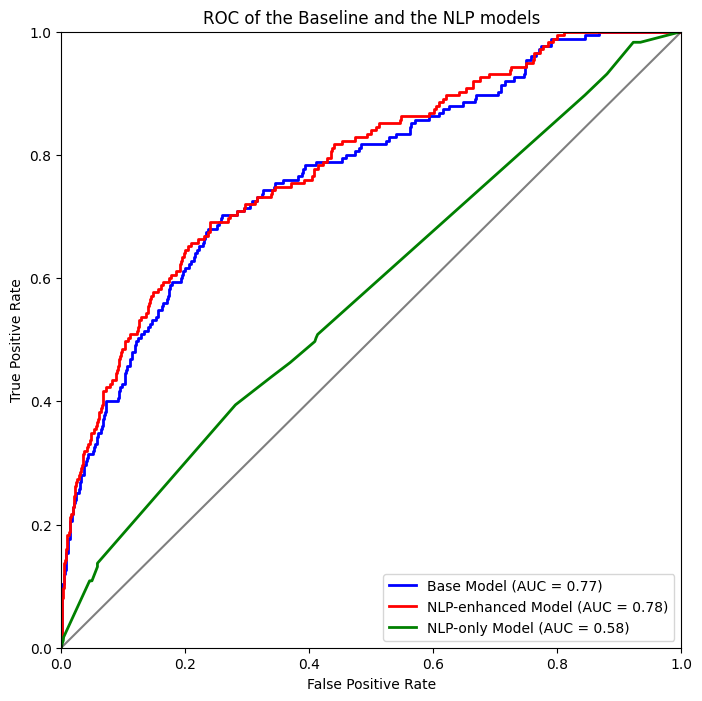

In [87]:
_ = plt.figure(figsize=(8, 8))
_ = plt.plot(fpr_base, tpr_base, color='blue', lw=2, label='Base Model (AUC = %0.2f)' % roc_auc_base)
_ = plt.plot(fpr_nlp, tpr_nlp, color='red', lw=2, label='NLP-enhanced Model (AUC = %0.2f)' % roc_auc_nlp)
_ = plt.plot(fpr_nlp_only, tpr_nlp_only, color='green', lw=2, label='NLP-only Model (AUC = %0.2f)' % roc_auc_nlp_only)
_ = plt.plot([0, 1], [0, 1], color='black', alpha=0.5)
_ = plt.xlim(0, 1)
_ = plt.ylim(0, 1)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
_ = plt.legend(loc='lower right')
_ = plt.title('ROC of the Baseline and the NLP models')

_ = plt.savefig('roc_curve.png', dpi=300)